In [1]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import pints
import scipy.stats
import seaborn as sns
sns.set_theme()

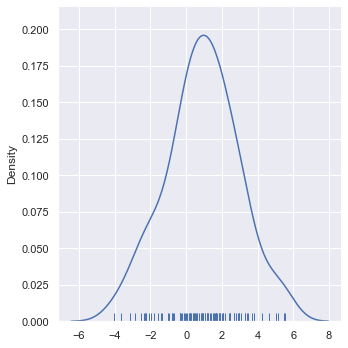

In [2]:
true_parameters = [1.3, 2.12]
data = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=100)

sns.displot(data, kind='kde', rug=True)
plt.show()

In [3]:
class GaussianLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations

    def __call__(self, parameters):
        mean, sigma = parameters
        score = np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(self._observations))

        return score

    def n_parameters(self):
        return 2

    def get_parameter_names(self):
        return ['Mean', 'Std.']

    def get_id(self):
        return [None] * self.n_parameters()


class NaiveGaussianKDELogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000):
        self._observations = observations
        self._n_samples = int(n_samples)

    def __call__(self, parameters):
        # Sample from population distribution
        mean, sigma = parameters
        samples = np.random.normal(
            loc=mean, scale=sigma, size=self._n_samples)

        # Estimate mean and std from samples
        mean = np.mean(samples)
        sigma = np.std(samples, ddof=1)
        score = np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(self._observations))

        return score

    def n_parameters(self):
        return 2

    def get_parameter_names(self):
        return ['Mean', 'Std.']

    def get_id(self):
        return [None] * self.n_parameters()


class GaussianKDELogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = observations
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        standard_samples = parameters[:self._n_samples]
        mean, sigma = parameters[self._n_samples:]
        samples = mean + standard_samples * sigma

        # Estimate mean and std from samples
        mean = np.mean(samples)
        sigma = np.std(samples, ddof=1)
        score = np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(self._observations))

        return score

    def evaluateS1(self, parameters):
        standard_samples = np.array(parameters[:self._n_samples])
        mean, std = parameters[self._n_samples:]
        samples = mean + standard_samples * std

        # Estimate mean and std from samples
        mu = np.mean(samples)
        sigma = np.std(samples, ddof=1)

        # Compute sensitivity of mean and sigma to input params
        dmu_dsamples = std / self._n_samples
        dmu_dmean = 1
        dmu_dstd = np.sum(standard_samples) / self._n_samples
        dsigma_dsamples = (
            std * (samples - mu) / (self._n_samples - 1) - \
            mu * dmu_dsamples) / sigma
        dsigma_dmean = 0
        dsigma_dstd = np.sum(
            (samples - mu) * (standard_samples - dmu_dstd)
            ) / (self._n_samples - 1) / sigma

        # Propagate sensitivies through likelihood
        score, sens = self._normal.compute_sensitivities(
            parameters=[sigma],
            model_output=np.array([mu] * len(self._observations)),
            model_sensitivities=np.broadcast_to(np.hstack([
                dmu_dsamples, dmu_dmean, dmu_dstd]), shape=(100, 3)),
            observations=self._observations)

        # Collect sensitivities
        # dp/dsamples = dp/dmu * dmu/dsample + dp/dsigma * dsigma/dsample
        # dp/dmean = dp/dmu * dmu/dmean + dp/dsigma * dsigma/dmean
        # dp/dstd = dp/dmu * dmu/dstd + dp/dsigma * dsigma/dstd
        sensitivities = np.empty(shape=self.n_parameters())
        sensitivities[:self._n_samples] = sens[0] + sens[3] * dsigma_dsamples
        sensitivities[self._n_samples] = sens[1] + sens[3] * dsigma_dmean
        sensitivities[-1] = sens[2] + sens[3] * dsigma_dstd

        return score, sensitivities

    def n_parameters(self):
        return self._n_samples + 2

    def get_parameter_names(self):
        return [
            'Sample' for _ in range(self._n_samples)] + ['Mean', 'Std.']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] + [None] * 2

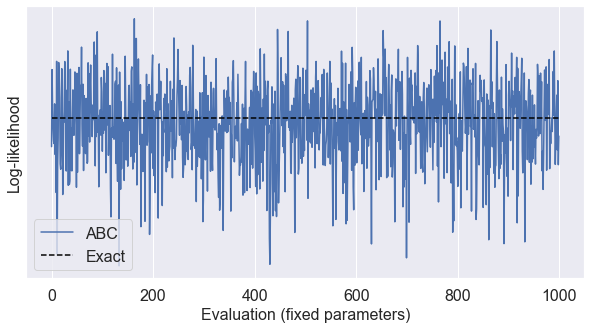

In [9]:
n_repeats = 1000

fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(10, 5))

# Compute exact log-likelihood
scores_exact = np.empty(n_repeats)
log_likelihood = GaussianLogLikelihood(observations=data)
for idr in range(n_repeats):
    scores_exact[idr] = log_likelihood(true_parameters)

# Compute naive Gaussian KDE log-likelihood
scores_naive = np.empty(n_repeats)
log_likelihood = NaiveGaussianKDELogLikelihood(
    observations=data, n_samples=1000)
for idr in range(n_repeats):
    scores_naive[idr] = log_likelihood(true_parameters)

# Compute Gaussian KDE log-likelihood
scores = np.empty(n_repeats)
n_samples = 1000
parameters = np.hstack([
    np.random.normal(size=n_samples), true_parameters])
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
for idr in range(n_repeats):
    scores[idr] = log_likelihood(parameters)

ax.plot(np.arange(n_repeats), scores_naive, label='ABC', color=sns.color_palette()[0])
ax.plot(np.arange(n_repeats), scores_exact, label='Exact', color='black', linestyle='--')

fontsize = 16
ax.set_xlabel('Evaluation (fixed parameters)', fontsize=fontsize)
ax.set_ylabel('Log-likelihood', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.set_yticks([])
ax.legend(fontsize=fontsize)
plt.savefig('abc_stochastic_likelihood.pdf', bbox_inches='tight')
plt.show()

In [ ]:
n_repeats = 1000

# Compute exact log-likelihood
scores_exact = np.empty(n_repeats)
log_likelihood = GaussianLogLikelihood(observations=data)
for idr in range(n_repeats):
    scores_exact[idr] = log_likelihood(true_parameters)

# Compute naive Gaussian KDE log-likelihood
scores_naive = np.empty(n_repeats)
log_likelihood = NaiveGaussianKDELogLikelihood(
    observations=data, n_samples=1000)
for idr in range(n_repeats):
    scores_naive[idr] = log_likelihood(true_parameters)

# Compute Gaussian KDE log-likelihood
scores = np.empty(n_repeats)
n_samples = 1000
parameters = np.hstack([
    np.random.normal(size=n_samples), true_parameters])
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
for idr in range(n_repeats):
    scores[idr] = log_likelihood(parameters)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=np.arange(n_repeats),
    y=scores_exact,
    name='Exact'
))
fig.add_trace(go.Scatter(
    x=np.arange(n_repeats),
    y=scores_naive,
    name='Naive Gaussian KDE'
))
fig.add_trace(go.Scatter(
    x=np.arange(n_repeats),
    y=scores,
    name='Gaussian KDE'
))
fig.update_layout(
    xaxis_title='Repeat',
    yaxis_title='Log-likelihood'
)
fig.show()

## Run inference with exact likelihood

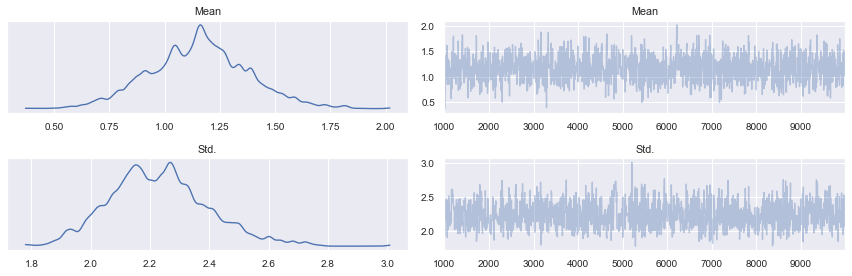

In [26]:
log_likelihood = GaussianLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1])
])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
n_iterations = 10000
posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 1000
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

## Run inference with naive Gaussian KDE likelihood

/Users/david/Workspace/sabs-r3/warfarin/venv/lib/python3.7/site-packages/arviz/stats/density_utils.py:481: UserWarning:

Your data appears to have a single value or no finite values

/Users/david/Workspace/sabs-r3/warfarin/venv/lib/python3.7/site-packages/arviz/stats/density_utils.py:481: UserWarning:

Your data appears to have a single value or no finite values



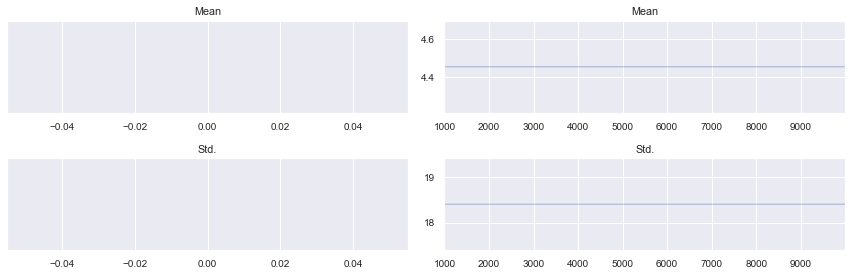

In [27]:
log_likelihood = NaiveGaussianKDELogLikelihood(
    observations=data, n_samples=100)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1])
])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
n_iterations = 10000
posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 1000
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

## Run inference with Gaussian KDE likelihood

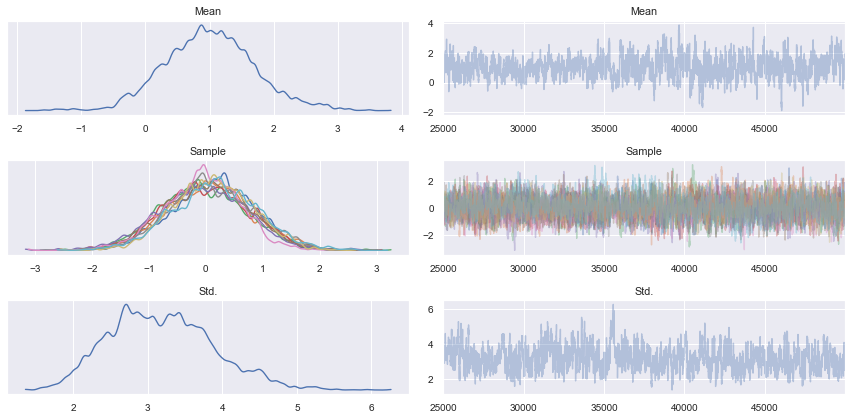

In [40]:
n_samples = 10
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1])
)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
n_iterations = 50000
posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 25000
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

### Reduce number of samples

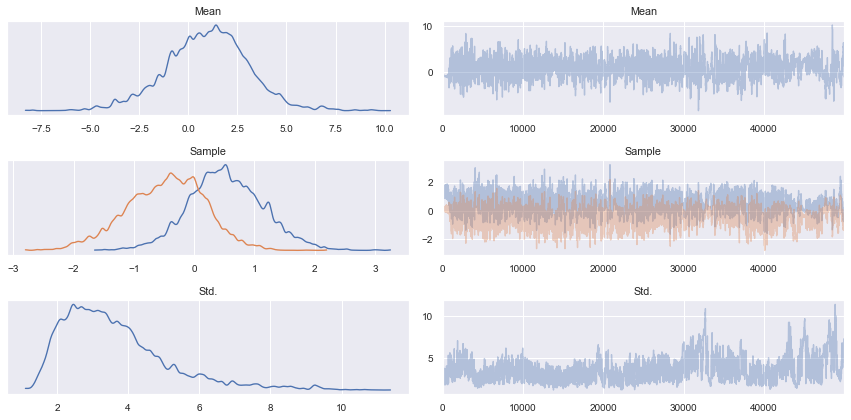

In [41]:
n_samples = 2
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.GaussianLogPrior(mean=0, sd=1),
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1])
)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
n_iterations = 50000
posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 0
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

## Increase the number of samples to 100

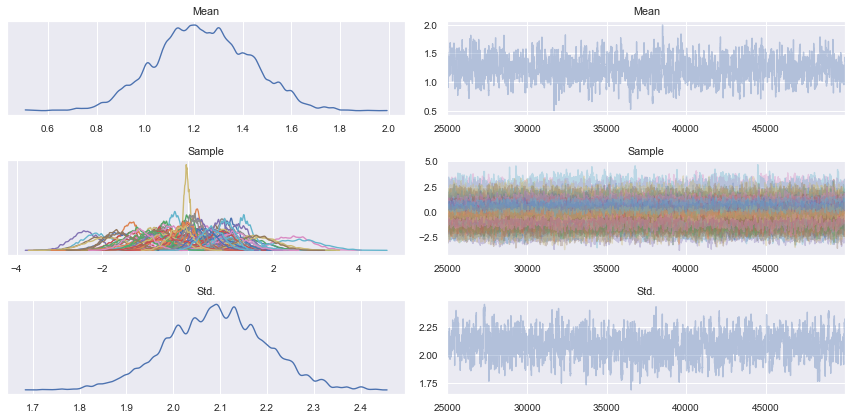

In [42]:
n_samples = 100
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(
    *[pints.GaussianLogPrior(mean=0, sd=1)] * n_samples,
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1])
)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
n_iterations = 50000
posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 25000
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

## Run with 50

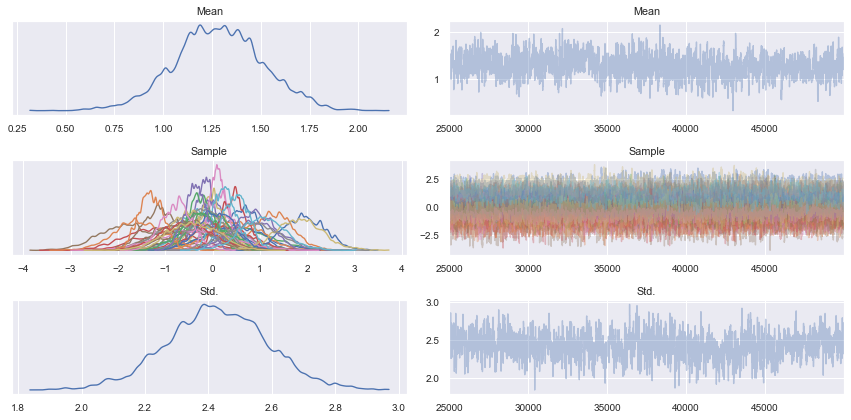

In [47]:
n_samples = 50
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(
    *[pints.GaussianLogPrior(mean=0, sd=1)] * n_samples,
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1])
)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
n_iterations = 50000
posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 25000
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

## Run with 25

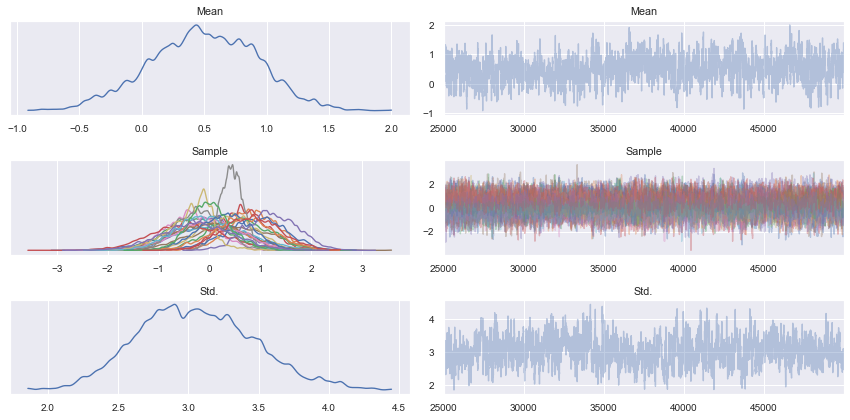

In [49]:
n_samples = 25
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(
    *[pints.GaussianLogPrior(mean=0, sd=1)] * n_samples,
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1])
)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
n_iterations = 50000
posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup = 25000
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

## Run with 100 and NUTS

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     10     0.125    2        0:00.0
1     11     0.25     1        0:00.0
2     14     0.125    2        0:00.0
3     23     0.39     5        0:00.0
20    870    0.749    48       0:00.6
40    1681   0.743    39       0:01.1
60    2439   0.765    37       0:01.6
80    3039   0.728    29       0:02.0
100   3631   0.771    29       0:02.3
120   10961  0.652    349      0:07.0
140   26813  0.743    755      0:17.4
160   29789  0.744087 142      0:20.0
180   30553  0.71     37       0:20.5
200   33605  0.751    146      0:22.6
220   38609  0.676    239      0:25.6
240   53949  0.782    731      0:34.8
260   64686  0.65     512      0:41.1
280   81818  0.752    816      0:51.4
300   84262  0.794    117      0:52.9
320   88210  0.745    188      0:55.3
340   92670  0.710881 213      0:58.0
360   97130  0.734172 213      1:00.6
380   102998  0.788    280      1:04.1
400   108866  0.7

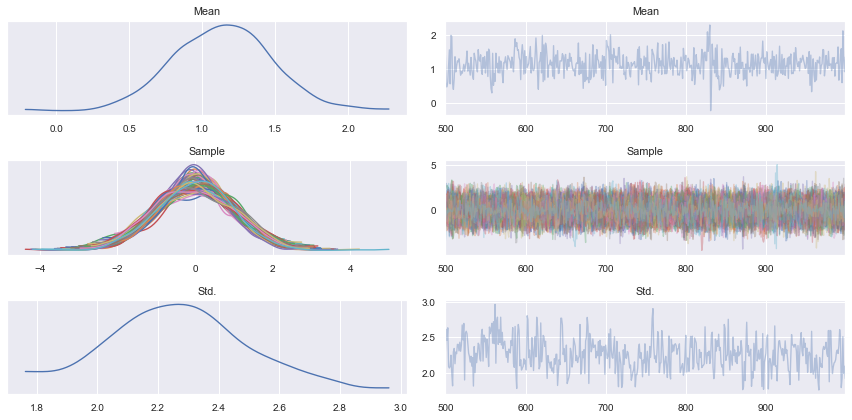

In [87]:
n_samples = 100
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(
    *[pints.GaussianLogPrior(mean=0, sd=1)] * n_samples,
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1])
)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1000
posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

## Run with 1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     13     0.238    4        0:00.1
1     14     0.25     1        0:00.1
2     17     0.125    2        0:00.1
3     31     0.394    7        0:00.2
20    544    0.741    29       0:02.2
40    1580   0.782    50       0:08.7
60    2159   0.752076 28       0:11.0
80    2709   0.746    27       0:13.0
100   3315   0.764    29       0:15.3
120   3848   0.701    26       0:17.3
140   4364   0.765    25       0:19.2
160   4775   0.733    20       0:20.7
180   5211   0.749801 21       0:22.3
200   5551   0.761    17       0:23.5
220   6107   0.744    27       0:25.5
240   6591   0.764    24       0:27.2
260   6932   0.721    17       0:28.5
280   7288   0.747033 17       0:29.8
300   7812   0.769    25       0:31.6
320   8208   0.741    19       0:33.0
340   8572   0.764    18       0:34.3
360   8888   0.762    16       0:35.4
380   9268   0.745    19       0:36.9
400   9648   0.79 

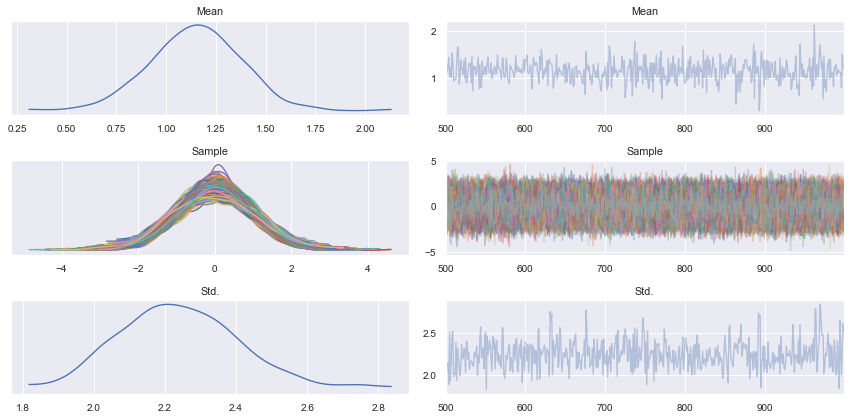

In [88]:
n_samples = 1000
log_likelihood = GaussianKDELogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(
    *[pints.GaussianLogPrior(mean=0, sd=1)] * n_samples,
    pints.UniformLogPrior(
        -10 * true_parameters[0],
        10 * true_parameters[0]),
    pints.UniformLogPrior(
        0.01 * true_parameters[1],
        10 * true_parameters[1])
)
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1000
posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 500
thinning = 1
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()